
## Introduction

This notebook was created for analysis and prediction making of the Car evaluation data set from UCI Machine Learning Library. The data set can be accessed separately from the UCI Machine Learning Repository page, [here](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation).

## Data Set Information

Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure:

- `class_val`: car category
- `buying`: buying price
- `maint`: price of the maintenance
- `doors`: number of doors
- `persons`: capacity in terms of persons to carry
- `lug_boot`: the size of luggage boot
- `safety`: estimated safety of the car

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety.

## Models

We will create 3 models in order to make predictions and compare them with the original paper. These models are:

- Logistic Regression
- Decision tree
- Neural Network

After the initial predictions, each model will be "optimized" by GridSearchCV estimator, which will search for the best set of hyperparameters for every model.

## Metrics

Metrics such as accuracy, cross-validation accuracy, mean squared error (MSE) and mean average error (MAE) will be used for all the models.

## Import libraries/packages

In [1]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

##################################

### Metrics ###
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, classification_report

## Part 1: Load and clean the data

In [3]:
# Load the data.
file = 'car.csv'
data = pd.read_csv(file)

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying       1728 non-null object
maint        1728 non-null object
doors        1728 non-null object
persons      1728 non-null object
lug_boot     1728 non-null object
safety       1728 non-null object
class_val    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
# Shape of the data set.
print("The data set has {} rows and {} columns.".format(data.shape[0],data.shape[1]))

The data set has 1728 rows and 7 columns.


In [5]:
# Check for missing values.
data.isna().any()

buying       False
maint        False
doors        False
persons      False
lug_boot     False
safety       False
class_val    False
dtype: bool

In [6]:
# Check for duplicate rows.
data.duplicated().any()

False

In [7]:
# Checking the values from each column.
for col in data.columns:
    print("Column:", col)
    print(data[col].value_counts(),'\n')

Column: buying
vhigh    432
low      432
med      432
high     432
Name: buying, dtype: int64 

Column: maint
vhigh    432
low      432
med      432
high     432
Name: maint, dtype: int64 

Column: doors
5more    432
3        432
4        432
2        432
Name: doors, dtype: int64 

Column: persons
more    576
4       576
2       576
Name: persons, dtype: int64 

Column: lug_boot
big      576
med      576
small    576
Name: lug_boot, dtype: int64 

Column: safety
low     576
med     576
high    576
Name: safety, dtype: int64 

Column: class_val
unacc    1210
acc       384
good       69
vgood      65
Name: class_val, dtype: int64 



In [7]:
# Plotting the values of each column.
for i in data.columns:
    labels = data[i].unique()
    values = data[i].value_counts()
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(title=go.layout.Title(text='Value distribution for column: "{}"'.format(i),x=.5))
    fig.show()

Since all the columns are categorical, we change the data types to "category". This will come in handy in case we want to sort any column of the data set.

In [8]:
# Create category types.
buying_type = CategoricalDtype(['low','med','high','vhigh'], ordered=True)
maint_type = CategoricalDtype(['low','med','high','vhigh'], ordered=True)
doors_type = CategoricalDtype(['2','3','4','5more'], ordered=True)
persons_type = CategoricalDtype(['2','4','more'], ordered=True)
lug_boot_type = CategoricalDtype(['small','med','big'], ordered=True)
safety_type = CategoricalDtype(['low','med','high'], ordered=True)
class_type = CategoricalDtype(['unacc','acc','good','vgood'], ordered=True)

# Convert all categorical values to category type.
data.buying = data.buying.astype(buying_type)
data.maint = data.maint.astype(maint_type)
data.doors = data.doors.astype(doors_type)
data.persons = data.persons.astype(persons_type)
data.lug_boot = data.lug_boot.astype(lug_boot_type)
data.safety = data.safety.astype(safety_type)
data.class_val = data.class_val.astype(class_type)

## Part 2: Preprocessing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [9]:
# Convert categories into integers for each column.
data.buying=data.buying.replace({'low':0, 'med':1, 'high':2, 'vhigh':3})
data.maint=data.maint.replace({'low':0, 'med':1, 'high':2, 'vhigh':3})
data.doors=data.doors.replace({'2':0, '3':1, '4':2, '5more':3})
data.persons=data.persons.replace({'2':0, '4':1, 'more':2})
data.lug_boot=data.lug_boot.replace({'small':0, 'med':1, 'big':2})
data.safety=data.safety.replace({'low':0, 'med':1, 'high':2})
data.class_val=data.class_val.replace({'unacc':0, 'acc':1, 'good':2, 'vgood':3})

In [10]:
# The data set after the conversion.
data.head()

,buying,maint,doors,persons,lug_boot,safety,class_val
0,3,3,0,0,0,0,0
1,3,3,0,0,0,1,0
2,3,3,0,0,0,2,0
3,3,3,0,0,1,0,0
4,3,3,0,0,1,1,0


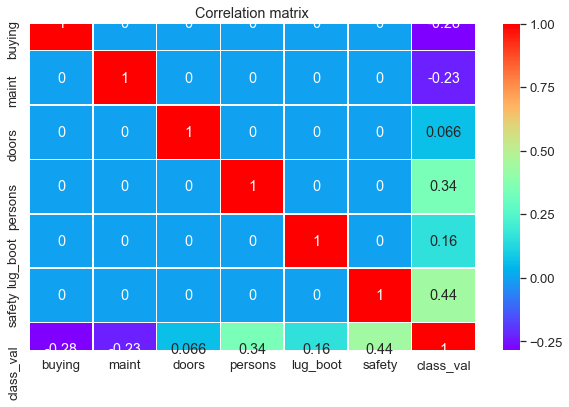

In [12]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.heatmap(data.corr(),annot=True, cmap='rainbow',linewidth=0.5)
plt.title('Correlation matrix');

In [13]:
# Choose attribute columns and class column.
X=data[data.columns[:-1]]
y=data['class_val']

In [14]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network

Each model will be trained and make a prediction for the test set. Accuracy, f1 score, confusion matrix and ROC will be calculated for each model. Then we will use the `GridSearchCV` module to tune our models and search for the best hyperparameters in order to increase the accuracy of each model.

## Logistic Regression

In [14]:
# Initialize a Logistic Regression classifier.
logreg=LogisticRegression(solver='saga', multi_class='auto', random_state=42, n_jobs=-1)

# Train the classifier.
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [15]:
# Make predictions.
log_pred=logreg.predict(X_test)

# CV score
logreg_cv = cross_val_score(logreg,X_train,y_train,cv=10)

## Metrics for Logistic Regression

In [16]:
# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, log_pred))

# Explained average absolute error (average error).
print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, log_pred))

# Explained variance score: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# CV Accuracy
print('CV Accuracy: %.3f' % logreg_cv.mean())

Mean squared error (MSE): 0.306
Mean absolute error (MAE): 0.218
Accuracy: 0.819
CV Accuracy: 0.823


## Confusion Matrix for Logistic Regression

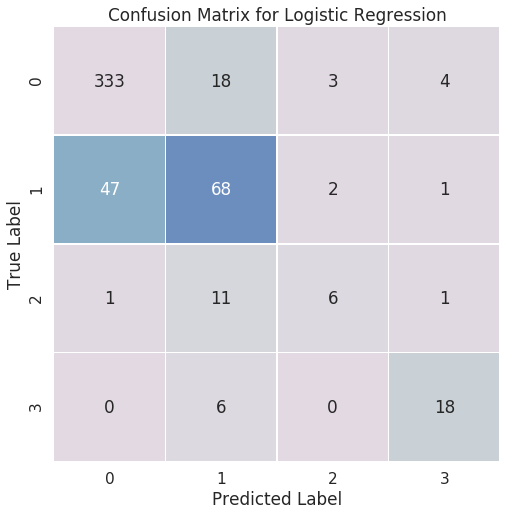

In [17]:
# Plot confusion matrix for Logistic regression.
logreg_matrix = confusion_matrix(y_test,log_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(logreg_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression');

## Grid search for Logistic Regression

In [18]:
# Hyperparameters to be checked.
parameters = {'C':[0.0001,0.001, 0.01, 1, 0.1, 10, 100, 1000],
              'penalty':['none','l2'],
              'solver':['lbfgs','sag','saga','newton-cg']
             }

# Logistic Regression classifier.
default_logreg=LogisticRegression(multi_class='auto', random_state=42, n_jobs=-1)

# GridSearchCV estimator.
gs_logreg = GridSearchCV(default_logreg, parameters, cv=10, verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_logreg.fit(X_train,y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 640 out of 640 | elapsed:   43.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
                         'penalty': ['none', 'l2'],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [19]:
# Make predictions with the best parameters.
gs_log_pred=gs_logreg.predict(X_test)

## Metrics for GridSearchCV Logistic Regression

In [20]:
# Best parameters.
print("Best Logistic Regression Parameters: {}".format(gs_logreg.best_params_))

# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, gs_log_pred))

# Explained average absolute error (average error).
print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, gs_log_pred))

# Cross validation accuracy for the best parameters.
print('CV Accuracy: %0.3f' % gs_logreg.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_logreg.score(X_test,y_test)))

Best Logistic Regression Parameters: {'C': 0.0001, 'penalty': 'none', 'solver': 'sag'}
Mean squared error (MSE): 0.291
Mean absolute error (MAE): 0.206
CV Accuracy: 0.831
Accuracy: 0.829


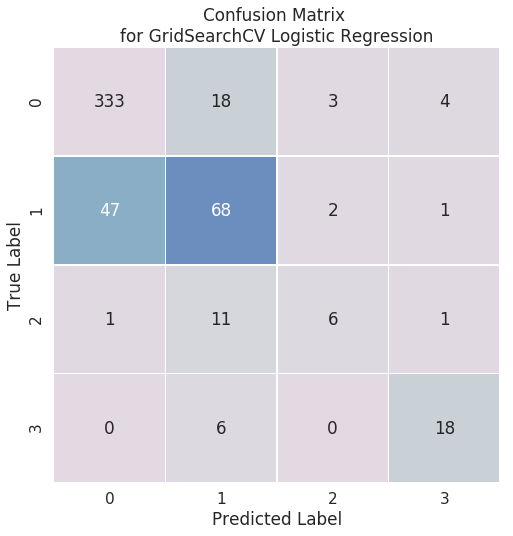

In [21]:
# Plot confusion matrix for GridSearchCV Logistic regression.
gs_logreg_matrix = confusion_matrix(y_test,log_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(gs_logreg_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix \nfor GridSearchCV Logistic Regression');

## Decision tree

In [15]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

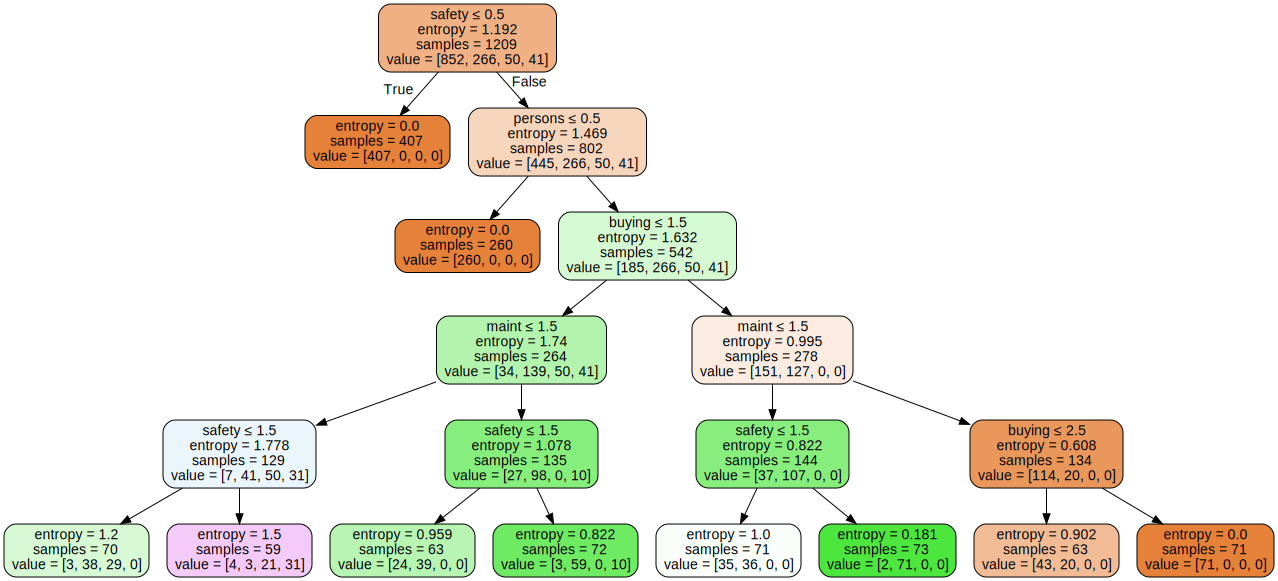

In [17]:
# Plot the tree.

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = tree.export_graphviz(tr, out_file=None, feature_names=X.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

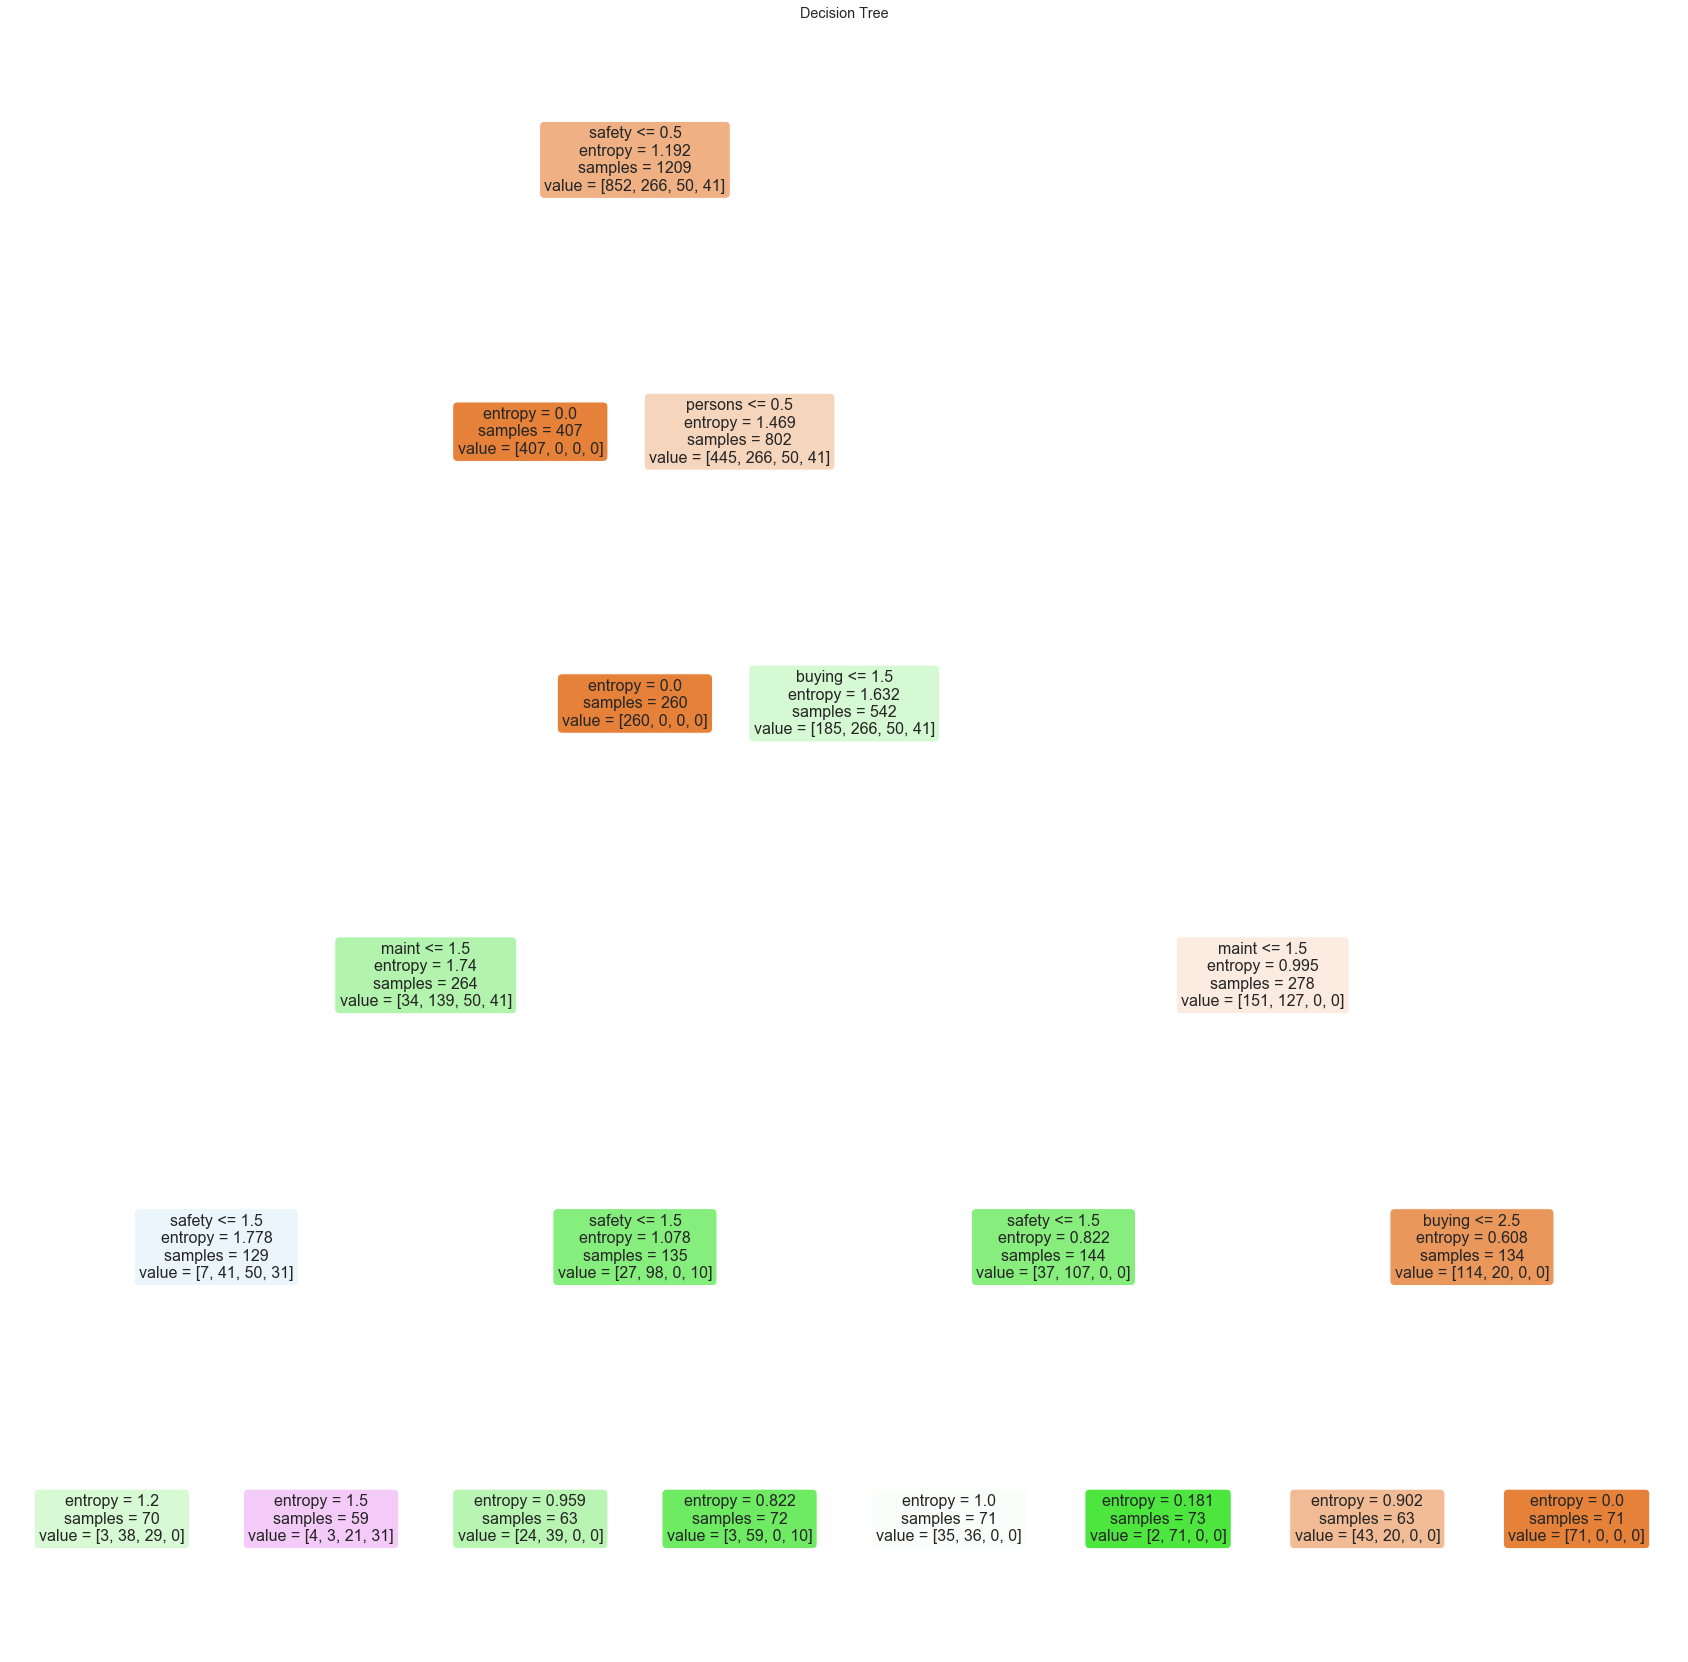

In [22]:
# Plot the tree.
fig=plt.figure(figsize=(30,30))
tree.plot_tree(tr.fit(X_train, y_train),feature_names=X.columns,filled=True,rounded=True,fontsize=16);
plt.title('Decision Tree');

In [24]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- safety <= 0.50
|   |--- class: 0
|--- safety >  0.50
|   |--- persons <= 0.50
|   |   |--- class: 0
|   |--- persons >  0.50
|   |   |--- buying <= 1.50
|   |   |   |--- maint <= 1.50
|   |   |   |   |--- safety <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- safety >  1.50
|   |   |   |   |   |--- class: 3
|   |   |   |--- maint >  1.50
|   |   |   |   |--- safety <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- safety >  1.50
|   |   |   |   |   |--- class: 1
|   |   |--- buying >  1.50
|   |   |   |--- maint <= 1.50
|   |   |   |   |--- safety <= 1.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- safety >  1.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- maint >  1.50
|   |   |   |   |--- buying <= 2.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- buying >  2.50
|   |   |   |   |   |--- class: 0



In [25]:
# Make predictions.
tr_pred=tr.predict(X_test)

# CV score
tr_cv = cross_val_score(tr,X_train,y_train,cv=10)

## Metrics for Decision tree

In [26]:
# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, tr_pred))

# Explained average absolute error (average error).
print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, tr_pred))

# Explained variance score: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# CV Accuracy
print('CV Accuracy: %.3f' % tr_cv.mean())

Mean squared error (MSE): 0.189
Mean absolute error (MAE): 0.150
Accuracy: 0.869
CV Accuracy: 0.862


## Confusion Matrix for Decision tree

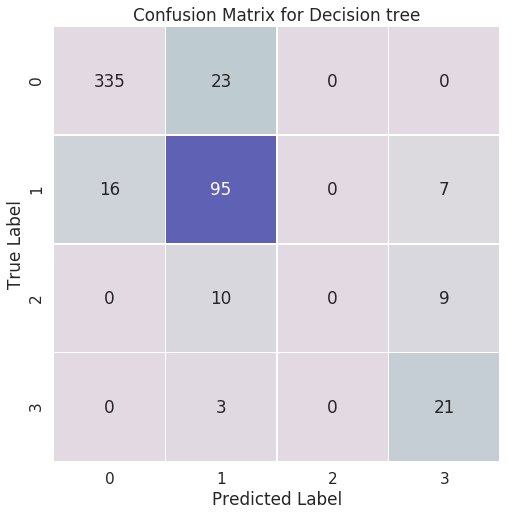

In [27]:
# Print confusion matrix for Decision tree.
tr_matrix = confusion_matrix(y_test,tr_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(tr_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision tree');

## Grid search for Decision tree

In [28]:
# Hyperparameters to be checked.
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
             }

# Default Decision tree estimator.
default_tr = tree.DecisionTreeClassifier(random_state=42)

# GridSearchCV estimator.
gs_tree = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_tree.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.4s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
  

In [29]:
# Make predictions with the best parameters.
gs_tree_pred=gs_tree.predict(X_test)

## Metrics for GridSearchCV Decision tree

In [30]:
# Best parameters.
print("Best Decision tree Parameters: {}".format(gs_tree.best_params_))

# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, gs_tree_pred))

# Explained average absolute error (average error).
print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, gs_tree_pred))

# Cross validation accuracy for the best parameters.
print('CV accuracy: %0.3f' % gs_tree.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_tree.score(X_test,y_test)))

Best Decision tree Parameters: {'criterion': 'entropy', 'max_depth': 11}
Mean squared error (MSE): 0.054
Mean absolute error (MAE): 0.039
CV accuracy: 0.983
Accuracy: 0.969


## Confusion Matrix for GridSearchCV Decision tree

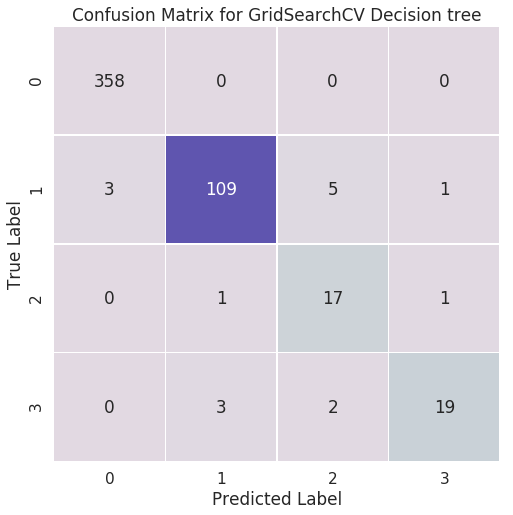

In [31]:
# Print confusion matrix for GridSearchCV Decision tree.
gs_tr_matrix = confusion_matrix(y_test,gs_tree_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(gs_tr_matrix,annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV Decision tree');

## Neural network (MLP)

In [32]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(5),max_iter=1000, random_state=42, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [33]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score
mlp_cv = cross_val_score(mlp,X_train,y_train,cv=10)

## Metrics for Neural Network (MLP)

In [34]:
# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, mlp_pred))

# Explained average absolute error (average error).
print("Mean absolute error (MAE): %.3f" % mean_absolute_error(y_test, mlp_pred))

# Explained variance score: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# CV Accuracy
print('CV Accuracy: %.3f' % mlp_cv.mean())

Mean squared error (MSE): 0.123
Mean absolute error (MAE): 0.100
Accuracy: 0.911
CV Accuracy: 0.925


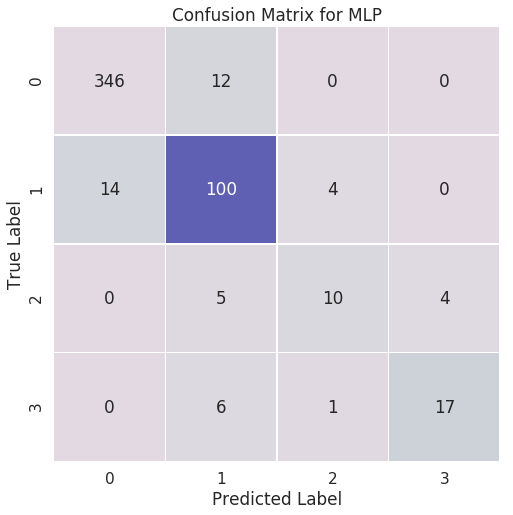

In [35]:
# Plot confusion matrix for MLP.
mlp_matrix = confusion_matrix(y_test,mlp_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(mlp_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for MLP');

## Grid search for Neural Network

In [36]:
# Hyperparameters to be checked.
parameters = {'activation':['logistic','tanh','relu'],
              'solver': ['lbfgs','adam','sgd'],
              'alpha':10.0 ** -np.arange(1,3),
              'hidden_layer_sizes':[(5),(100),(3),(4),(3,1),(5,3)]}

# MLP estimator.
default_mlp = MLPClassifier(random_state=42)

# GridSearchCV estimator.
gs_mlp = GridSearchCV(default_mlp, parameters, cv=10, n_jobs=-1,verbose=1)

# Train the GridSearchCV estimator and search for the best parameters.
gs_mlp.fit(X_train,y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  7.8min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_st...fle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
         

In [37]:
# Make predictions with the best parameters.
gs_mlp_pred=gs_mlp.predict(X_test)

## Metrics for GridSearchCV MLP

In [38]:
# Best parameters.
print("Best MLP Parameters: {}".format(gs_mlp.best_params_))

# The mean squared error (relative error).
print("Mean squared error (MSE): %.3f" % mean_squared_error(y_test, gs_mlp_pred))

# Explained average absolute error (average error).
print("Average absolute error (MAE): %.3f" % mean_absolute_error(y_test, gs_mlp_pred))

# Cross validation accuracy for the best parameters.
print('CV accuracy: %0.3f' % gs_mlp.best_score_)

# Accuracy: 1 is perfect prediction.
print('Accuracy: %0.3f' % (gs_mlp.score(X_test,y_test)))

Best MLP Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}
Mean squared error (MSE): 0.033
Average absolute error (MAE): 0.025
CV accuracy: 0.988
Accuracy: 0.979


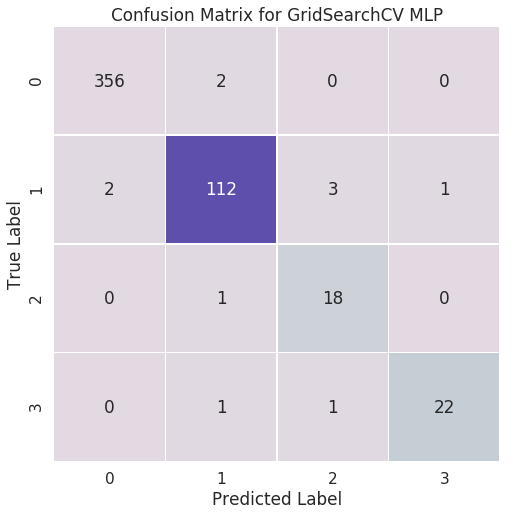

In [39]:
# Print confusion matrix for GridSearchCV MLP.
gs_mlp_matrix = confusion_matrix(y_test,gs_mlp_pred)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.4)
sns.heatmap(gs_mlp_matrix,annot=True, cbar=False, cmap='twilight',linewidth=0.5,fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for GridSearchCV MLP');

## Results

In [40]:
# Ploting metrics
errors=['Accuracy','CV-accuracy','MSE', 'MAE']

fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=errors, y=[logreg.score(X_test, y_test),logreg_cv.mean(),mean_squared_error(y_test, log_pred), mean_absolute_error(y_test, log_pred)]),
    go.Bar(name='Decision tree', x=errors, y=[tr.score(X_test, y_test),tr_cv.mean(),mean_squared_error(y_test, tr_pred), mean_absolute_error(y_test, tr_pred)]),
    go.Bar(name='MLP', x=errors, y=[mlp.score(X_test, y_test),mlp_cv.mean(),mean_squared_error(y_test, mlp_pred), mean_absolute_error(y_test, mlp_pred)]),
    go.Bar(name='GridSearchCV+Logistic Regression', x=errors, y=[gs_logreg.score(X_test, y_test),gs_logreg.best_score_,mean_squared_error(y_test, gs_log_pred), mean_absolute_error(y_test, gs_log_pred)]),
    go.Bar(name='GridSearchCV+Decision tree', x=errors, y=[gs_tree.score(X_test, y_test),gs_tree.best_score_,mean_squared_error(y_test, gs_tree_pred), mean_absolute_error(y_test, gs_tree_pred)]),
    go.Bar(name='GridSearchCV+MLP', x=errors, y=[gs_mlp.score(X_test, y_test),gs_mlp.best_score_,mean_squared_error(y_test, gs_mlp_pred), mean_absolute_error(y_test, gs_mlp_pred)])
])

fig.update_layout(
    title='Metrics for each model',
    xaxis_tickfont_size=14,    
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [41]:
d={
'': ['Logistic Regression','GridSearchCV + Logistic Regression','Decision Tree','GridSearchCV + Decision Tree','Neural Network (MLP)','GridSearchCV + Neural Network (MLP)'],
'Accuracy': [logreg.score(X_test, y_test), gs_logreg.score(X_test,y_test),tr.score(X_test, y_test),gs_tree.score(X_test,y_test),mlp.score(X_test, y_test),gs_mlp.score(X_test, y_test)],
'CV Accuracy': [logreg_cv.mean(), gs_logreg.best_score_, tr_cv.mean(),gs_tree.best_score_,mlp_cv.mean(),gs_mlp.best_score_],
'MSE': [mean_squared_error(y_test, log_pred),mean_squared_error(y_test, gs_log_pred),mean_squared_error(y_test, tr_pred), mean_squared_error(y_test, gs_tree_pred),mean_squared_error(y_test, mlp_pred),mean_squared_error(y_test, gs_mlp_pred)],
'MAE': [mean_absolute_error(y_test, log_pred),mean_absolute_error(y_test, gs_log_pred),mean_absolute_error(y_test, tr_pred), mean_absolute_error(y_test, gs_tree_pred),mean_absolute_error(y_test, mlp_pred),mean_absolute_error(y_test, gs_mlp_pred)]
}

results=pd.DataFrame(data=d).round(3).set_index('')
results

,Accuracy,CV Accuracy,MSE,MAE
,,,,
Logistic Regression,0.819,0.823,0.306,0.218
GridSearchCV + Logistic Regression,0.829,0.831,0.291,0.206
Decision Tree,0.869,0.862,0.189,0.150
GridSearchCV + Decision Tree,0.969,0.983,0.054,0.039
Neural Network (MLP),0.911,0.925,0.123,0.100
GridSearchCV + Neural Network (MLP),0.979,0.988,0.033,0.025
